In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib

from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
from torch.autograd import Variable
from biotorch.module.biomodule import BioModule

from ANN import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

cifar_dset_train = torchvision.datasets.CIFAR100('../../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR100('../../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = "cuda"
# criterion = torch.nn.MSELoss().to(device)
criterion = torch.nn.CrossEntropyLoss()
activation = F.relu
architecture = [int(32*32*3), 1000, 500, 100]
# model = BioModule(MLP(architecture, activation = activation, final_layer_activation = activation), mode = "fa", layer_config = {"type": "fa", "options": {"init": "kaiming"}}).to(device)
# model =MLP(architecture, activation = activation, final_layer_activation = False).to(device)
model = FeedbackAlignmentMLP(architecture, activation = activation, final_layer_activation = None).to(device)

In [5]:
# for idx in range(len(model.module.linear_layers)):
#     model.module.linear_layers[idx].scaling_factor *= 100
#     model.module.linear_layers[idx].init_parameters()

In [6]:
evaluateClassification(model, train_loader, "cuda")

Accuracy :	 0.00974


0.00974

In [7]:
# # specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.Adam(model.parameters(),lr = 5*1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.001, nesterov=False)

lr_decay_step = 50
lr_decay = 0.9
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay)
trn_acc_list = []
tst_acc_list = []

n_epochs = 20
for epoch_ in range(n_epochs):
    model.train()
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = Variable(x.to(device)), Variable(y.to(device))
        y_one_hot = F.one_hot(y, num_classes=100)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y) # Use this if criterion = torch.nn.CrossEntropyLoss()
#         loss = criterion(y_hat,y_one_hot.to(torch.float32)) # Use this if criterion = torch.nn.MSELoss().to(device)
        # backward pass: compute gradient of the loss with respect to model parameters
        model.zero_grad()
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
    
    scheduler.step()
    trn_acc = evaluateClassification(model, train_loader, device, False)
    tst_acc = evaluateClassification(model, test_loader, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

2500it [00:13, 185.43it/s]
19it [00:00, 181.34it/s]

Epoch : 1, Train Accuracy : 0.06884, Test Accuracy : 0.0662


2500it [00:13, 184.48it/s]
19it [00:00, 184.87it/s]

Epoch : 2, Train Accuracy : 0.08404, Test Accuracy : 0.0841


2500it [00:13, 184.05it/s]
19it [00:00, 183.60it/s]

Epoch : 3, Train Accuracy : 0.08028, Test Accuracy : 0.0844


2500it [00:13, 185.41it/s]
19it [00:00, 185.70it/s]

Epoch : 4, Train Accuracy : 0.09416, Test Accuracy : 0.0842


2500it [00:13, 183.63it/s]
19it [00:00, 185.26it/s]

Epoch : 5, Train Accuracy : 0.09584, Test Accuracy : 0.0866


2500it [00:13, 185.13it/s]
19it [00:00, 185.69it/s]

Epoch : 6, Train Accuracy : 0.11426, Test Accuracy : 0.102


2500it [00:13, 183.37it/s]
19it [00:00, 181.13it/s]

Epoch : 7, Train Accuracy : 0.1157, Test Accuracy : 0.1032


2500it [00:13, 185.80it/s]
19it [00:00, 184.31it/s]

Epoch : 8, Train Accuracy : 0.12374, Test Accuracy : 0.106


2500it [00:13, 184.48it/s]
19it [00:00, 182.34it/s]

Epoch : 9, Train Accuracy : 0.1228, Test Accuracy : 0.1035


2500it [00:13, 185.55it/s]
19it [00:00, 185.11it/s]

Epoch : 10, Train Accuracy : 0.12754, Test Accuracy : 0.1086


2500it [00:13, 185.59it/s]
19it [00:00, 183.27it/s]

Epoch : 11, Train Accuracy : 0.13246, Test Accuracy : 0.1088


2500it [00:13, 185.84it/s]
19it [00:00, 184.72it/s]

Epoch : 12, Train Accuracy : 0.15854, Test Accuracy : 0.125


2500it [00:13, 184.96it/s]
19it [00:00, 181.50it/s]

Epoch : 13, Train Accuracy : 0.14766, Test Accuracy : 0.1139


2500it [00:13, 184.16it/s]
18it [00:00, 178.90it/s]

Epoch : 14, Train Accuracy : 0.16062, Test Accuracy : 0.1253


2500it [00:13, 184.67it/s]
19it [00:00, 184.95it/s]

Epoch : 15, Train Accuracy : 0.17216, Test Accuracy : 0.1337


2500it [00:13, 182.83it/s]
19it [00:00, 182.57it/s]

Epoch : 16, Train Accuracy : 0.17382, Test Accuracy : 0.1348


2500it [00:13, 185.02it/s]
19it [00:00, 182.54it/s]

Epoch : 17, Train Accuracy : 0.16844, Test Accuracy : 0.1249


2500it [00:13, 183.19it/s]
19it [00:00, 182.06it/s]

Epoch : 18, Train Accuracy : 0.19198, Test Accuracy : 0.143


2500it [00:13, 184.56it/s]
19it [00:00, 183.49it/s]

Epoch : 19, Train Accuracy : 0.1951, Test Accuracy : 0.1428


2500it [00:13, 183.22it/s]


Epoch : 20, Train Accuracy : 0.20586, Test Accuracy : 0.1463


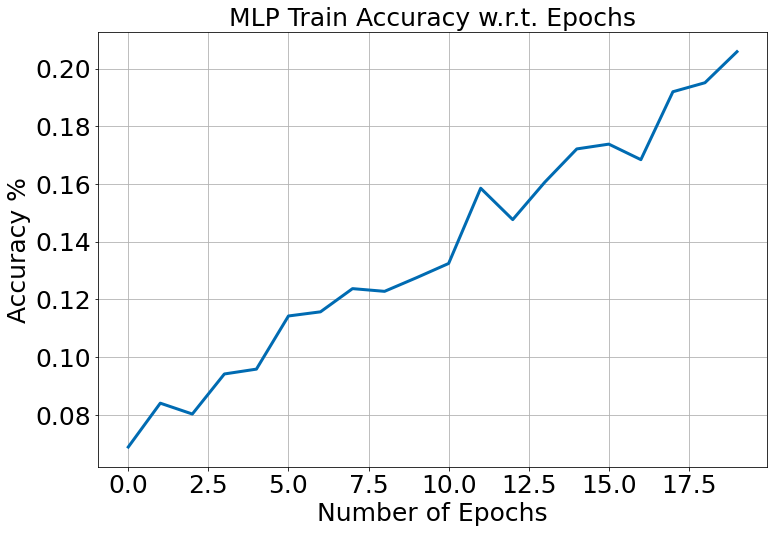

In [8]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'MLP Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

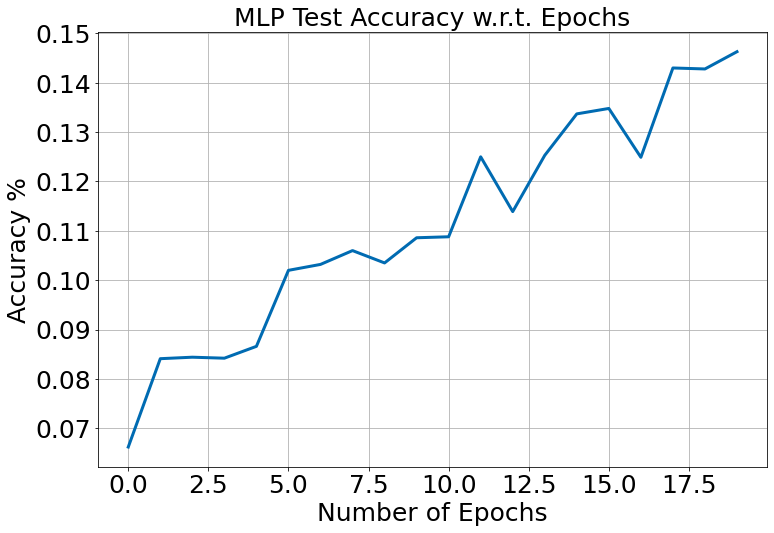

In [9]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'MLP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)